In [ ]:
!pip install --quiet yfinance

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as pdr
import datetime as dt
from scipy import stats
import yfinance as yf
import time

sns.set_style('whitegrid')
%matplotlib inline


In [ ]:

# Define your portfolio and date range
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']     # example equities
weights = np.array([0.25, 0.25, 0.25, 0.25])    # equal-weight portfolio

start = dt.datetime(2020, 1, 1)
end = dt.datetime.today()

# Container for adjusted close prices
prices = pd.DataFrame()

for ticker in tickers:
    print(f"Fetching {ticker}…", end=" ")
    try:
        # pull via yfinance.Ticker.history (auto_adjust -> splits/divs handled)
        df = yf.Ticker(ticker).history(
            start=start.strftime('%Y-%m-%d'),
            end=end.strftime('%Y-%m-%d'),
            auto_adjust=True,
        )
        series = df['Close']
        print("✔︎ yfinance", end=" ")
    except Exception as e:
        # fallback to Stooq if yfinance fails
        print(f"✖ yfinance ({e}); falling back to Stooq", end=" ")
        df2 = pdr.DataReader(ticker, 'stooq', start, end)
        df2 = df2.sort_index()
        series = df2['Close']
    # align on our master date index
    prices[ticker] = series
    time.sleep(1)  # pause to respect rate limits
    print()

# drop leading NaNs if any, then forward-fill/back-fill gaps
prices = prices.dropna(how='all').ffill().bfill()

# quick sanity check
print(prices.tail())

Fetching AAPL… ✔︎ yfinance 
Fetching MSFT… ✔︎ yfinance 
Fetching GOOGL… ✔︎ yfinance 
Fetching AMZN… ✔︎ yfinance 
                                 AAPL        MSFT       GOOGL        AMZN
Date                                                                     
2025-06-16 00:00:00-04:00  198.419998  479.140015  176.770004  216.100006
2025-06-17 00:00:00-04:00  195.639999  478.040009  175.949997  214.820007
2025-06-18 00:00:00-04:00  196.580002  480.239990  173.320007  212.520004
2025-06-20 00:00:00-04:00  201.000000  477.399994  166.639999  209.690002
2025-06-23 00:00:00-04:00  201.500000  486.000000  165.190002  208.470001


In [ ]:
#Daily log-returns measure how a security’s price changes from one day to the next
# by taking the natural logarithm of the ratio of today’s price to yesterday’s price.


# log-return = ln(P_t / P_{t-1})
logR = np.log(prices / prices.shift(1)).dropna()
logR.head()

,AAPL,MSFT,GOOGL,AMZN
Date,,,,
2020-01-03 00:00:00-05:00,-0.009769,-0.012530,-0.005245,-0.012213
2020-01-06 00:00:00-05:00,0.007936,0.002581,0.026305,0.014776
2020-01-07 00:00:00-05:00,-0.004714,-0.009159,-0.001934,0.002089
2020-01-08 00:00:00-05:00,0.015958,0.015803,0.007092,-0.007839
2020-01-09 00:00:00-05:00,0.021018,0.012416,0.010443,0.004788


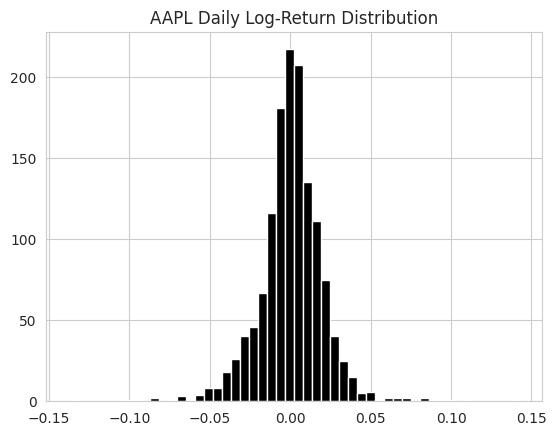

In [ ]:
  # Plot one example series for visual Check
  # You’ll see a bell-shaped histogram.
  # log-return = ln(P_t / P_{t-1})
  logR['AAPL'].hist(bins=50, alpha=1.0,color='black')
  plt.title('AAPL Daily Log-Return Distribution')
  plt.show()

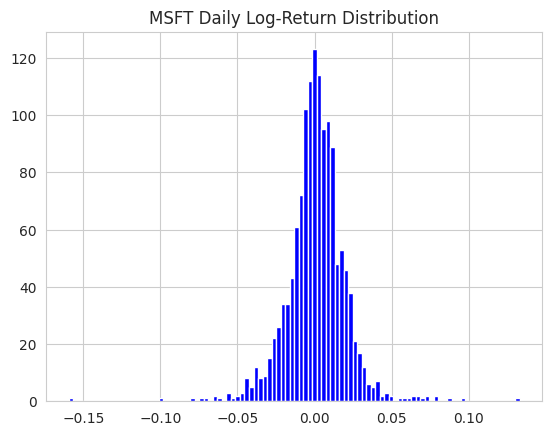

In [ ]:
logR['MSFT'].hist(bins=100, alpha=1.0,color='blue')
plt.title('MSFT Daily Log-Return Distribution')
plt.show()

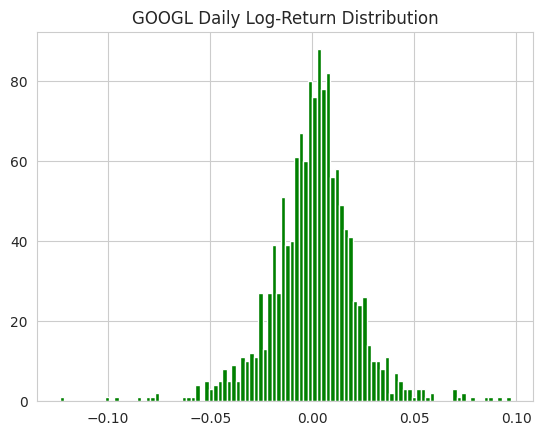

In [ ]:
logR['GOOGL'].hist(bins=100, alpha=1.0,color='green')
plt.title('GOOGL Daily Log-Return Distribution')
plt.show()

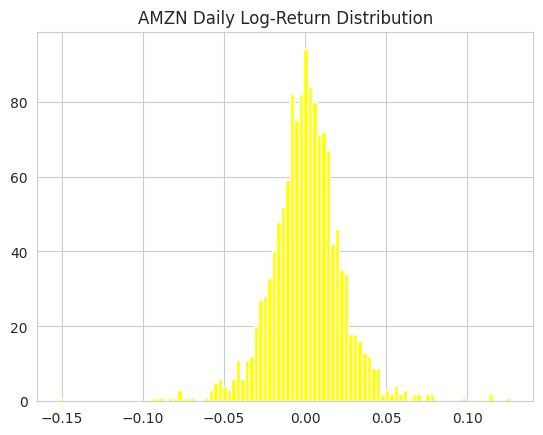

In [ ]:
logR['AMZN'].hist(bins=100, alpha=1.0,color='yellow')
plt.title('AMZN Daily Log-Return Distribution')
plt.show()

In [ ]:
summary = pd.DataFrame({
    'Mean': logR.mean(),
    'Variation': logR.var(),
    'Skewness': logR.skew(),
    'Kurtosis': logR.kurtosis()
})
print(summary)

           Mean  Variation  Skewness  Kurtosis
AAPL   0.000743   0.000421  0.021090  6.252399
MSFT   0.000841   0.000368 -0.169068  7.516323
GOOGL  0.000646   0.000428 -0.223309  3.630980
AMZN   0.000573   0.000519 -0.069395  4.207377


In [ ]:
# 4.1 Fit Normal: mean μ, std σ
mu_norm, sigma_norm = logR.stack().mean(), logR.stack().std(ddof=1)

# 95% CI for mean under Normal: μ ± z*·σ/√N
N = logR.size
z95 = stats.norm.ppf(0.975)
ci_mu_norm = (mu_norm - z95*sigma_norm/np.sqrt(N),
              mu_norm + z95*sigma_norm/np.sqrt(N))

# 95% CI for σ via Chi-square:
df = N-1
chi2_low, chi2_high = stats.chi2.ppf([0.025,0.975], df)
ci_sigma_norm = (sigma_norm*np.sqrt(df/chi2_high),
                 sigma_norm*np.sqrt(df/chi2_low))
print("Normal fit:")
print(f"  μ = {mu_norm:.5f}, 95% CI {ci_mu_norm}")
print(f"  σ = {sigma_norm:.5f}, 95% CI {ci_sigma_norm}")

Normal fit:
  μ = 0.00070, 95% CI (np.float64(0.00014983335876862303), np.float64(0.0012512598875255854))
  σ = 0.02083, 95% CI (np.float64(0.020448311624556174), np.float64(0.021227461719305854))


In [ ]:
# 4.2 Fit Student’s t

# Fit t-distribution to the pooled returns
# returns_flat = all asset returns concatenated
returns_flat = logR.stack().values
df_t, mu_t, sigma_t = stats.t.fit(returns_flat)


In [ ]:
print("Fitted Student's t-distribution parameters: ")
print(f" Degrees of freedom (df): {df_t:.2f}")
print(f" Mean (mu): {mu_t:.5f}")
print(f" Scale (sigma): {sigma_t:.5f}")

Fitted Student's t-distribution parameters: 
 Degrees of freedom (df): 3.65
 Mean (mu): 0.00104
 Scale (sigma): 0.01440


In [ ]:
# 95% CI for μ and o of a t-fit is more complex; we can bootstrap them:

B = 1000
estimates = np.array([stats.t.fit(np.random.choice (returns_flat, size=N, replace=True))
                      for _ in range(B)])
ci_mu_t = np.percentile(estimates[:,1], [2.5,97.5])
ci_sigma_t = np.percentile (estimates[:,2], [2.5,97.5])
print("\nStudent's t fit:")
print(f" df = {df_t:.1f}, μ = {mu_t:.5f}, σ = {sigma_t:.5f}")
print (f" 95% CI for u (bootstrap): {ci_mu_t}")
print(f" 95% CI for a (bootstrap): {ci_sigma_t}")


Student's t fit:
 df = 3.7, μ = 0.00104, σ = 0.01440
 95% CI for u (bootstrap): [0.0005792 0.0014733]
 95% CI for a (bootstrap): [0.01392    0.01490469]


In [ ]:
# Parametric VaR under Normal:
#   VaR = − [ μ_p + σ_p · z_{0.05} ]
# where μ_p, σ_p are portfolio mean & vol.
# Compute portfolio returns:
portR = logR.dot(weights)

μ_p = portR.mean()
σ_p = portR.std(ddof=1)

z05 = stats.norm.ppf(0.05)
VaR_norm = - (μ_p + σ_p * z05)

In [ ]:

# Parametric VaR under Student's t:=
#   t05 t.ppf(0.05, df_t)
t05 = stats.t.ppf(0.05, df_t)
VaR_t = (mu_t + sigma_t * t05) * 1 # 1-day

In [ ]:
# Historical VaR (non-parametric):
hist_var = -np.percentile(portR, 5)

print("1-Day 95% VaR:")
print(f"  Parametric (Normal):       {VaR_norm:.5f}")
print(f"  Parametric (Student’s t):  {VaR_t:.5f}")
print(f"  Historical (5th percentile): {hist_var:.5f}")

1-Day 95% VaR:
  Parametric (Normal):       0.02902
  Parametric (Student’s t):  -0.03051
  Historical (5th percentile): 0.02885


In [ ]:
# One-sample t-test: H0: μ=0 vs H1: μ≠0
t_stat, p_val = stats.ttest_1samp(portR, 0.0)
print("One-sample t-test on portfolio daily returns:")
print(f"  t-statistic = {t_stat:.3f},  p-value = {p_val:.3f}")

if p_val < 0.05:
    print("  → Reject H0: mean return is significantly different from zero.")
else:
    print("  → Fail to reject H0: no evidence mean return ≠ 0.")


# one-sample t-test is a statistical test used to check whether the
# mean (average) of a single sample is significantly different.

One-sample t-test on portfolio daily returns:
  t-statistic = 1.437,  p-value = 0.151
  → Fail to reject H0: no evidence mean return ≠ 0.


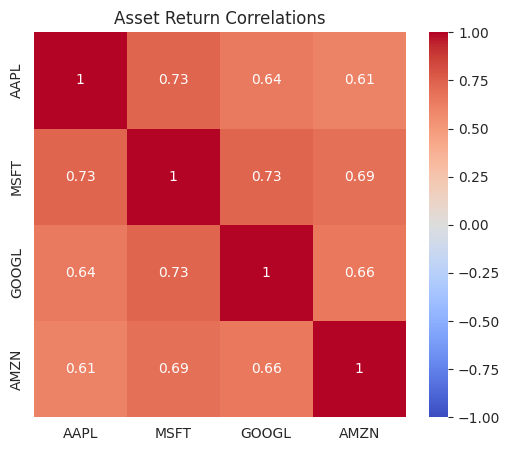

Weighted avg σ: 0.0208
Actual portfolio σ: 0.0181
Diversification benefit: 0.0027


In [ ]:
# 7. Correlation & Diversification Benefit
import seaborn as sns

# a) Correlation heatmap
corr = logR.corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Asset Return Correlations')
plt.show()

# b) Diversification benefit
σ_i = logR.std()                         # individual volatilities
σ_weighted = np.dot(weights, σ_i)        # naive weighted avg
σ_portfolio = σ_p                        # from earlier
print(f"Weighted avg σ: {σ_weighted:.4f}")
print(f"Actual portfolio σ: {σ_portfolio:.4f}")
print(f"Diversification benefit: {σ_weighted-σ_portfolio:.4f}")

Max Drawdown: -43.98%
From 2021-12-10 to 2023-01-05


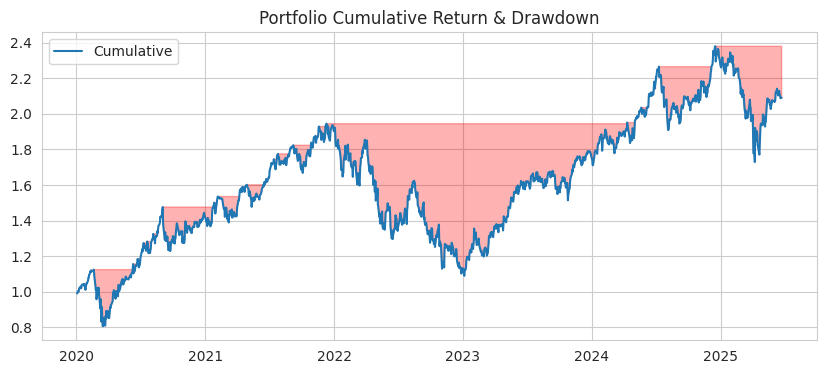

In [ ]:
# 8. Max Drawdown
cum_ret = (prices / prices.iloc[0]).prod(axis=1)  # cumulative portfolio growth?
# Actually for portfolio: cum_port = (portR + 1).cumprod()
cum_port = (portR + 1).cumprod()

rolling_max = cum_port.cummax()
drawdown   = (cum_port - rolling_max) / rolling_max

max_dd = drawdown.min()
end_date = drawdown.idxmin()
start_date = cum_port[:end_date].idxmax()
print(f"Max Drawdown: {max_dd:.2%}")
print(f"From {start_date.date()} to {end_date.date()}")

# Plot
plt.figure(figsize=(10,4))
plt.plot(cum_port, label='Cumulative')
plt.fill_between(drawdown.index, cum_port, rolling_max,
                 where=drawdown<0, color='red', alpha=0.3)
plt.title('Portfolio Cumulative Return & Drawdown')
plt.legend()
plt.show()

In [ ]:
# 9. Expected Shortfall (CVaR at 95%)
alpha = 0.05
# Historical ES
es_hist = - portR[portR <= np.percentile(portR, 5)].mean()
# Parametric ES under Normal: μ + σ·φ(z)/α
es_norm = - (μ_p - σ_p * stats.norm.pdf(z05) / alpha)

print(f"Historical ES (95%): {es_hist:.5f}")
print(f"Parametric Normal ES (95%): {es_norm:.5f}")


# On the worst 5% of days, you typically lose about 4.23% (historical).
# The Normal model estimates about 3.68%.
# These are larger than your VaR (e.g., 2.9%) → showing real risk in the tail.

Historical ES (95%): 0.04210
Parametric Normal ES (95%): 0.03657


In [ ]:
# 10. VaR Backtesting
var_series = - (portR.rolling(1).mean() + portR.rolling(1).std()*z05)
# For simplicity use constant VaR_norm
exceptions = portR < -VaR_norm
num_exc = exceptions.sum()
total   = len(portR)
print(f"Exceptions: {num_exc}/{total} days ({num_exc/total:.2%}, expected ~5%)")

Exceptions: 67/1374 days (4.88%, expected ~5%)


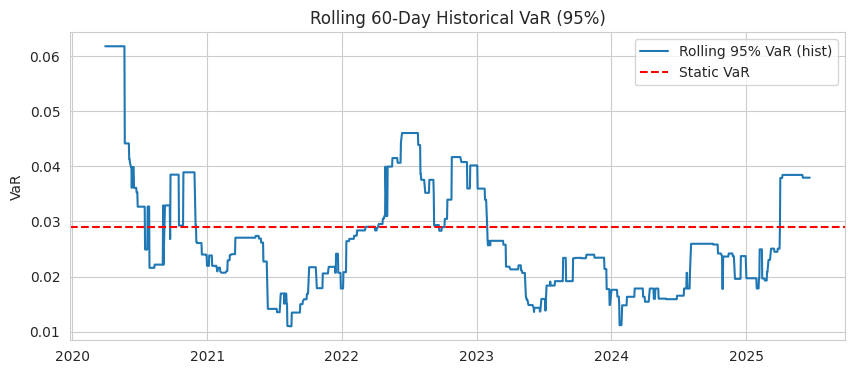

In [ ]:
# 11. Rolling 60-day VaR
window = 60
roll_var = portR.rolling(window).quantile(0.05).dropna()
plt.figure(figsize=(10,4))
plt.plot(-roll_var, label='Rolling 95% VaR (hist)')
plt.axhline(VaR_norm, color='red', linestyle='--', label='Static VaR')
plt.title('Rolling 60-Day Historical VaR (95%)')
plt.ylabel('VaR')
plt.legend()
plt.show()

In [ ]:
# 12. Jarque–Bera Normality Test
jb_stat, jb_p = stats.jarque_bera(portR)
print(f"JB statistic = {jb_stat:.2f}, p-value = {jb_p:.3f}")
if jb_p < 0.05:
    print("Reject normality at 5% level.")
else:
    print("Cannot reject normality.")

JB statistic = 1236.50, p-value = 0.000
Reject normality at 5% level.
